# Ficheux gate using the $\lvert 1 3 \rangle - \lvert 04 \rangle$ transition

The gates will be based on the following driven Hamiltonian of capacitively coupled fluxonium and transmon

$$H = H_F + H_T + V + H_{drive}$$,

where we have the fluxonium Hamiltonian

$$H_L= 4 E_{C,F} \hat{n}^2_F + \frac{1}{2}E_{L} \hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \varphi_{ext,F}\right), \quad [\hat{\varphi}_F, \hat{n}_F] = i$$,

the transmon Hamiltonian (treated immediately as a Duffing oscillator)

$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$,

where in terms of the transmon's charging energy $E_{C,T}$ and Josephson energy $E_{J, T}$ the transmon's angular velocity $\omega_T$ and anharmonicity $\delta_T$ are

$$ \omega_T = \frac{\sqrt{8 E_{C, T} E_{J, T}}}{\hbar}, \quad \delta_T = - \frac{E_{C,T}}{\hbar} $$.
In addition, the transmon's charge operator can be written as
$$ \hat{n}_T = \frac{i}{2} \biggl( \frac{E_{J, T}}{2 E_{C, T}} \biggr)^{1/4} \bigl( \hat{b}^{\dagger} - \hat{b} \bigr) = \frac{i}{2} \sqrt{\frac{\omega_T}{4 \lvert \delta_T \rvert} }\bigl( \hat{b}^{\dagger} - \hat{b} \bigr).$$

The coupling Hamiltonian is

$$V = J_C  \hat{n}_F \hat{n}_T$$,

and the drive Hamiltonian

$$H_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \left( \eta_F  \hat{n}_F + \eta_T \hat{n}_T \right)   \text{  with  } f\left( t \right) = f_0 \dfrac{f\left( t \right)}{f_0}. $$

In [41]:
import numpy as np
import sys
import qutip as qtp 
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
import xarray as xr
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from itertools import product
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.dpi'] = 75
from IPython.display import Image, display, Latex
import time
from itertools import product, combinations

In [36]:
# Fluxonium parameters (like Qubit A in Ficheux 2020): values in GHz (divided by h)
ec_f = 0.973 
el_f = 0.457 
ej_f = 5.899
# ec_f = 1.027 
# el_f = 0.684 
# ej_f = 5.768
flux_f = 1/2
n_fock_f = 100
# Transmon parameters: values in GHz divided by 2 \pi 
omega_t = 3.64 # taken to have same detuning as the 21-12 transition in fluxonium-fluxonium gate
delta_t = -0.3
n_fock_t = 3

Schematic of the Ficheux gate using the interaction between $\lvert 13 \rangle$ and $\lvert 04 \rangle$

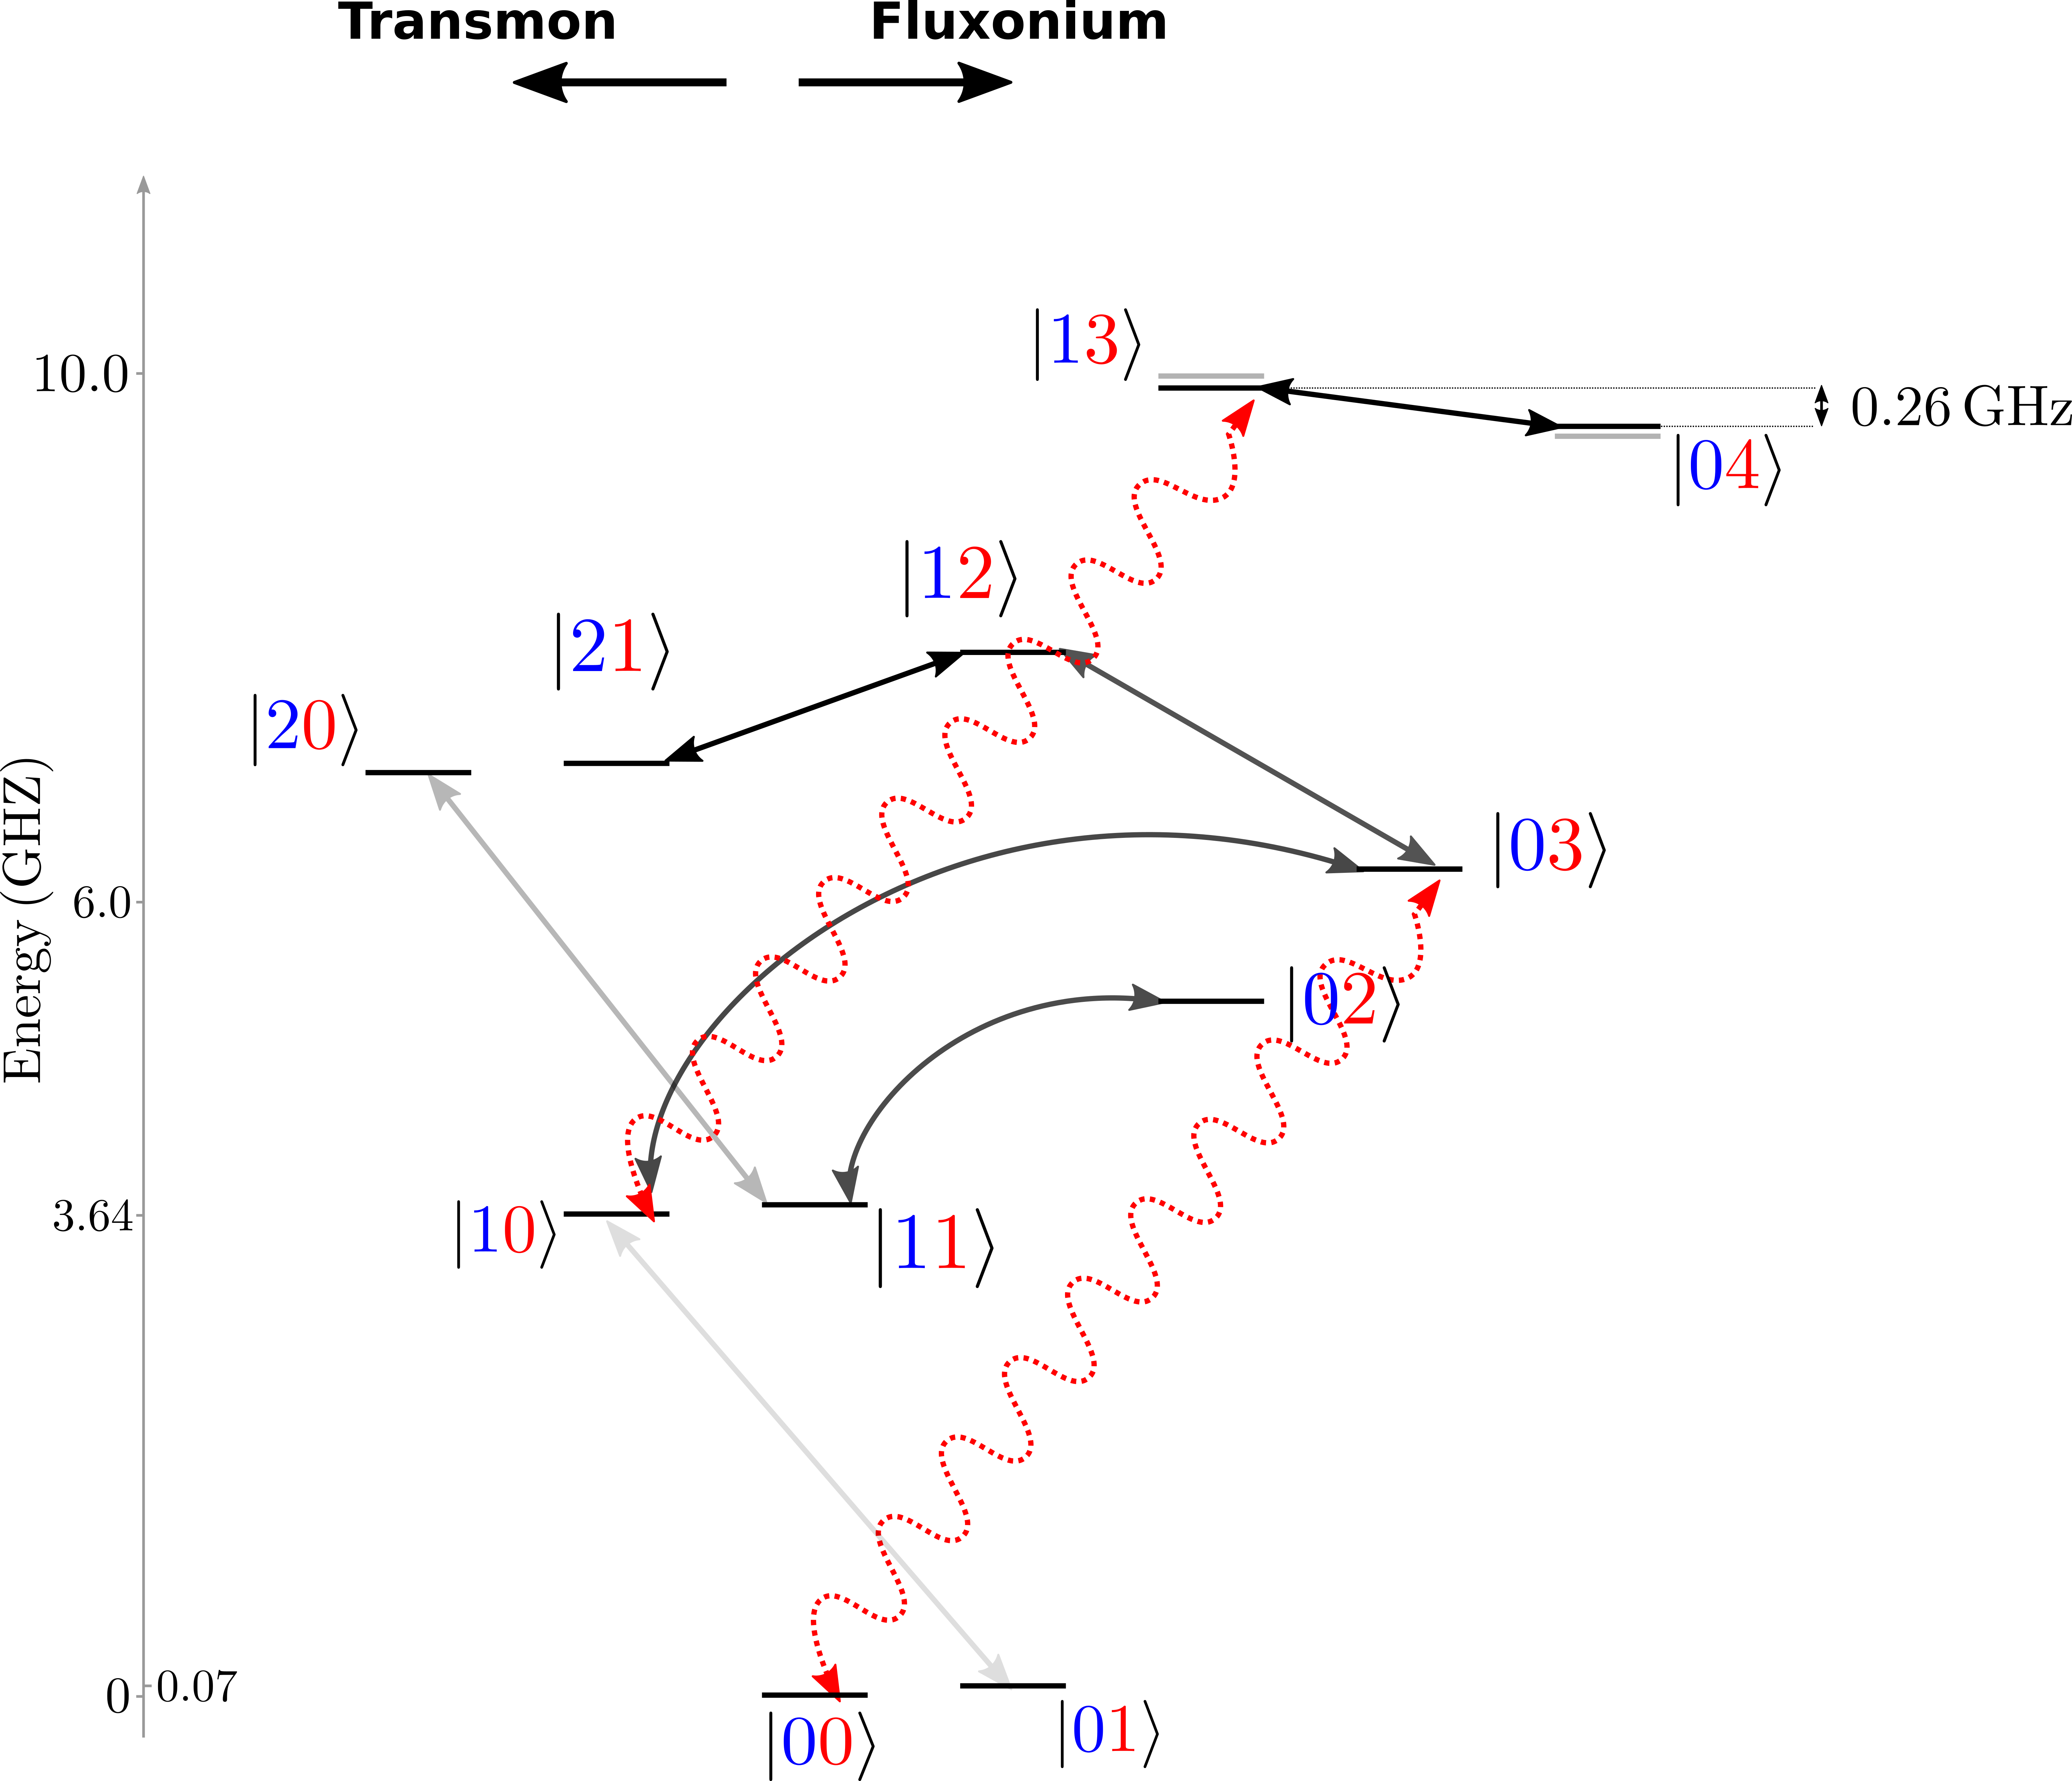

In [37]:
Image("transmon_fluxonium_couplings_04.png", width = 600)

Alternative scheme

In [38]:
levels_f = 7
levels_t = n_fock_t
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=n_fock_f)
trans = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=n_fock_t)
flx.diagonalize_basis(levels_f)
# The Simple Transmon is already diagonal
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t, eig_states_t = trans.eig_states(levels_t)

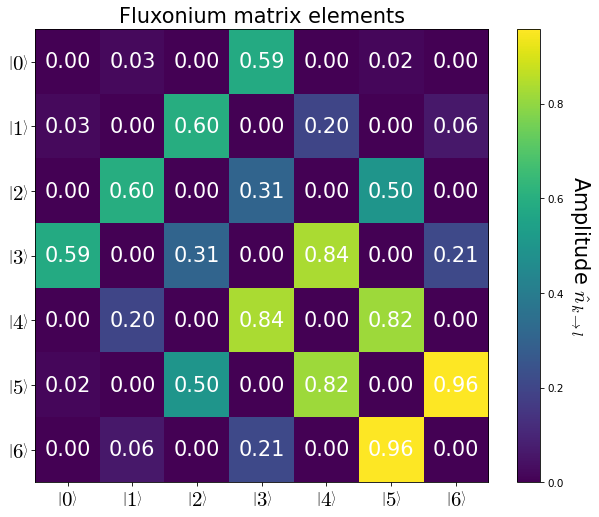

In [42]:
mat_elems_f = flx.mat_elements(operator='charge_op', levels=levels_f, as_xarray=True)
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_mat_elem(
    mat_elems: xarray.core.dataarray.DataArray, 
    levels: int, 
    opt: dict, 
    qubit: str
) -> None:
    levels_vec = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in levels_vec]
    fig, ax = plt.subplots(figsize=(10,8))
    plt.imshow(np.abs(mat_elems.data), cmap='viridis')
    for in_level, out_level in product(levels_vec, repeat=2):
        amplitude = abs(mat_elems.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center",
                color="white", fontsize=opt['fs'])
    ax.set_xticks(levels_vec)
    ax.set_yticks(levels_vec)
    ax.set_xticklabels(level_labels, fontsize=opt['fs'])
    ax.set_yticklabels(level_labels, fontsize=opt['fs'])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r"Amplitude $\hat{n}_{k \rightarrow l}$", rotation=-90, va="bottom", fontsize=opt['fs'])
    ax.set_title(qubit + ' matrix elements', fontsize=opt['fs'])
    plt.show()

plot_mat_elem(mat_elems_f, levels_f, plot_setup, 'Fluxonium')

In [43]:
display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(3, 4, energies_f[4] - energies_f[3] )))

<IPython.core.display.Latex object>

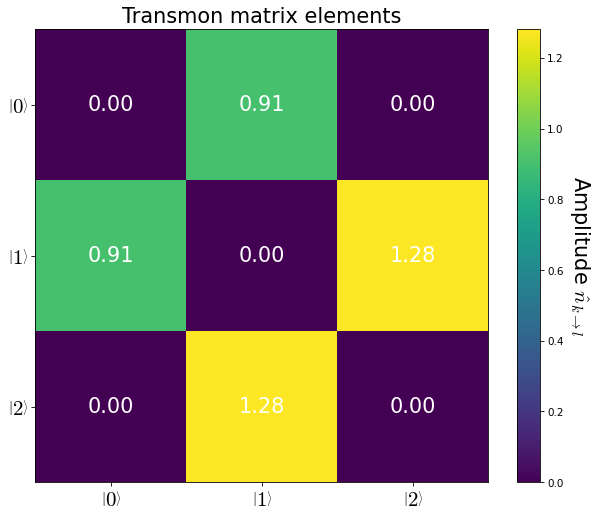

In [44]:
mat_elems_t = trans.mat_elements(operator='charge_op', levels=levels_t, as_xarray=True)
plot_mat_elem(mat_elems_t, levels_t, plot_setup, 'Transmon')

In [45]:
bare_energies_tf = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        bare_energies_tf[count] = energies_t[k] + energies_f[m]
        count += 1
label_converter = np.argsort(bare_energies_tf)

def labels_to_energy(
    lev_t: int, 
    lev_f: int, 
    energies: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_t*n_levels_f + lev_f
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def labels_to_state(
    lev_t: int, 
    lev_f: int, 
    eig_states: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_t*n_levels_f + lev_f
    index = np.where(label_converter==label)[0][0]
    return eig_states[index]

In [46]:
jc_ficheux = 0.224
jc = jc_ficheux*0.5 # GHz 1/10 the in Ficheux 2020 to consider rescaling of parameters
trans_flx = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_tf, eigstates_tf = trans_flx.eig_states()

In [47]:
display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(3, 4, energies_f[4] - energies_f[3] )))

<IPython.core.display.Latex object>

In [48]:
bare_energy_mat = np.zeros([levels_t, levels_f], dtype=float)
energy_mat = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        bare_energy_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, np.sort(bare_energies_tf), 
                                                         label_converter)
        energy_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, energies_tf, label_converter)

In this setup the residual $ZZ$ coupling is

In [49]:
def zz(energy_mat):
    return energy_mat[1, 1] + energy_mat[0, 0] - energy_mat[1, 0] - energy_mat[0, 1]

zz_coup = zz(energy_mat)
display(Latex(r'$\xi_{{ZZ}}/2 \pi$ =  {:.5f} MHz'.format(zz_coup*1000)))

<IPython.core.display.Latex object>

The Ficheux gate is based on the fact that the frequency of the $\lvert 00 \rangle - \lvert 03 \rvert$ transition is different than the frequency of the $\lvert 10 \rangle - \lvert 13 \rvert$ transition. In particular, this frequency difference
$$
\Delta = \frac{\lvert (E_{13} - E_{10}) - (E_{03} - E_{00}) \rvert}{h},
$$
sets the gate time simply as $t_{\mathrm{gate}} = 1/\Delta $

In [50]:
def delta_ficheux_new(energy_mat):
    return (energy_mat[1, 3] - energy_mat[1, 0]) - (energy_mat[0, 3] - energy_mat[0, 0])
delta_f_new = delta_ficheux_new(energy_mat)
display(Latex(r'$\Delta_{{13-04}} = $ {:.5f} MHz'.format(delta_f_new*1000)))

<IPython.core.display.Latex object>

# 1.1 Resonant version

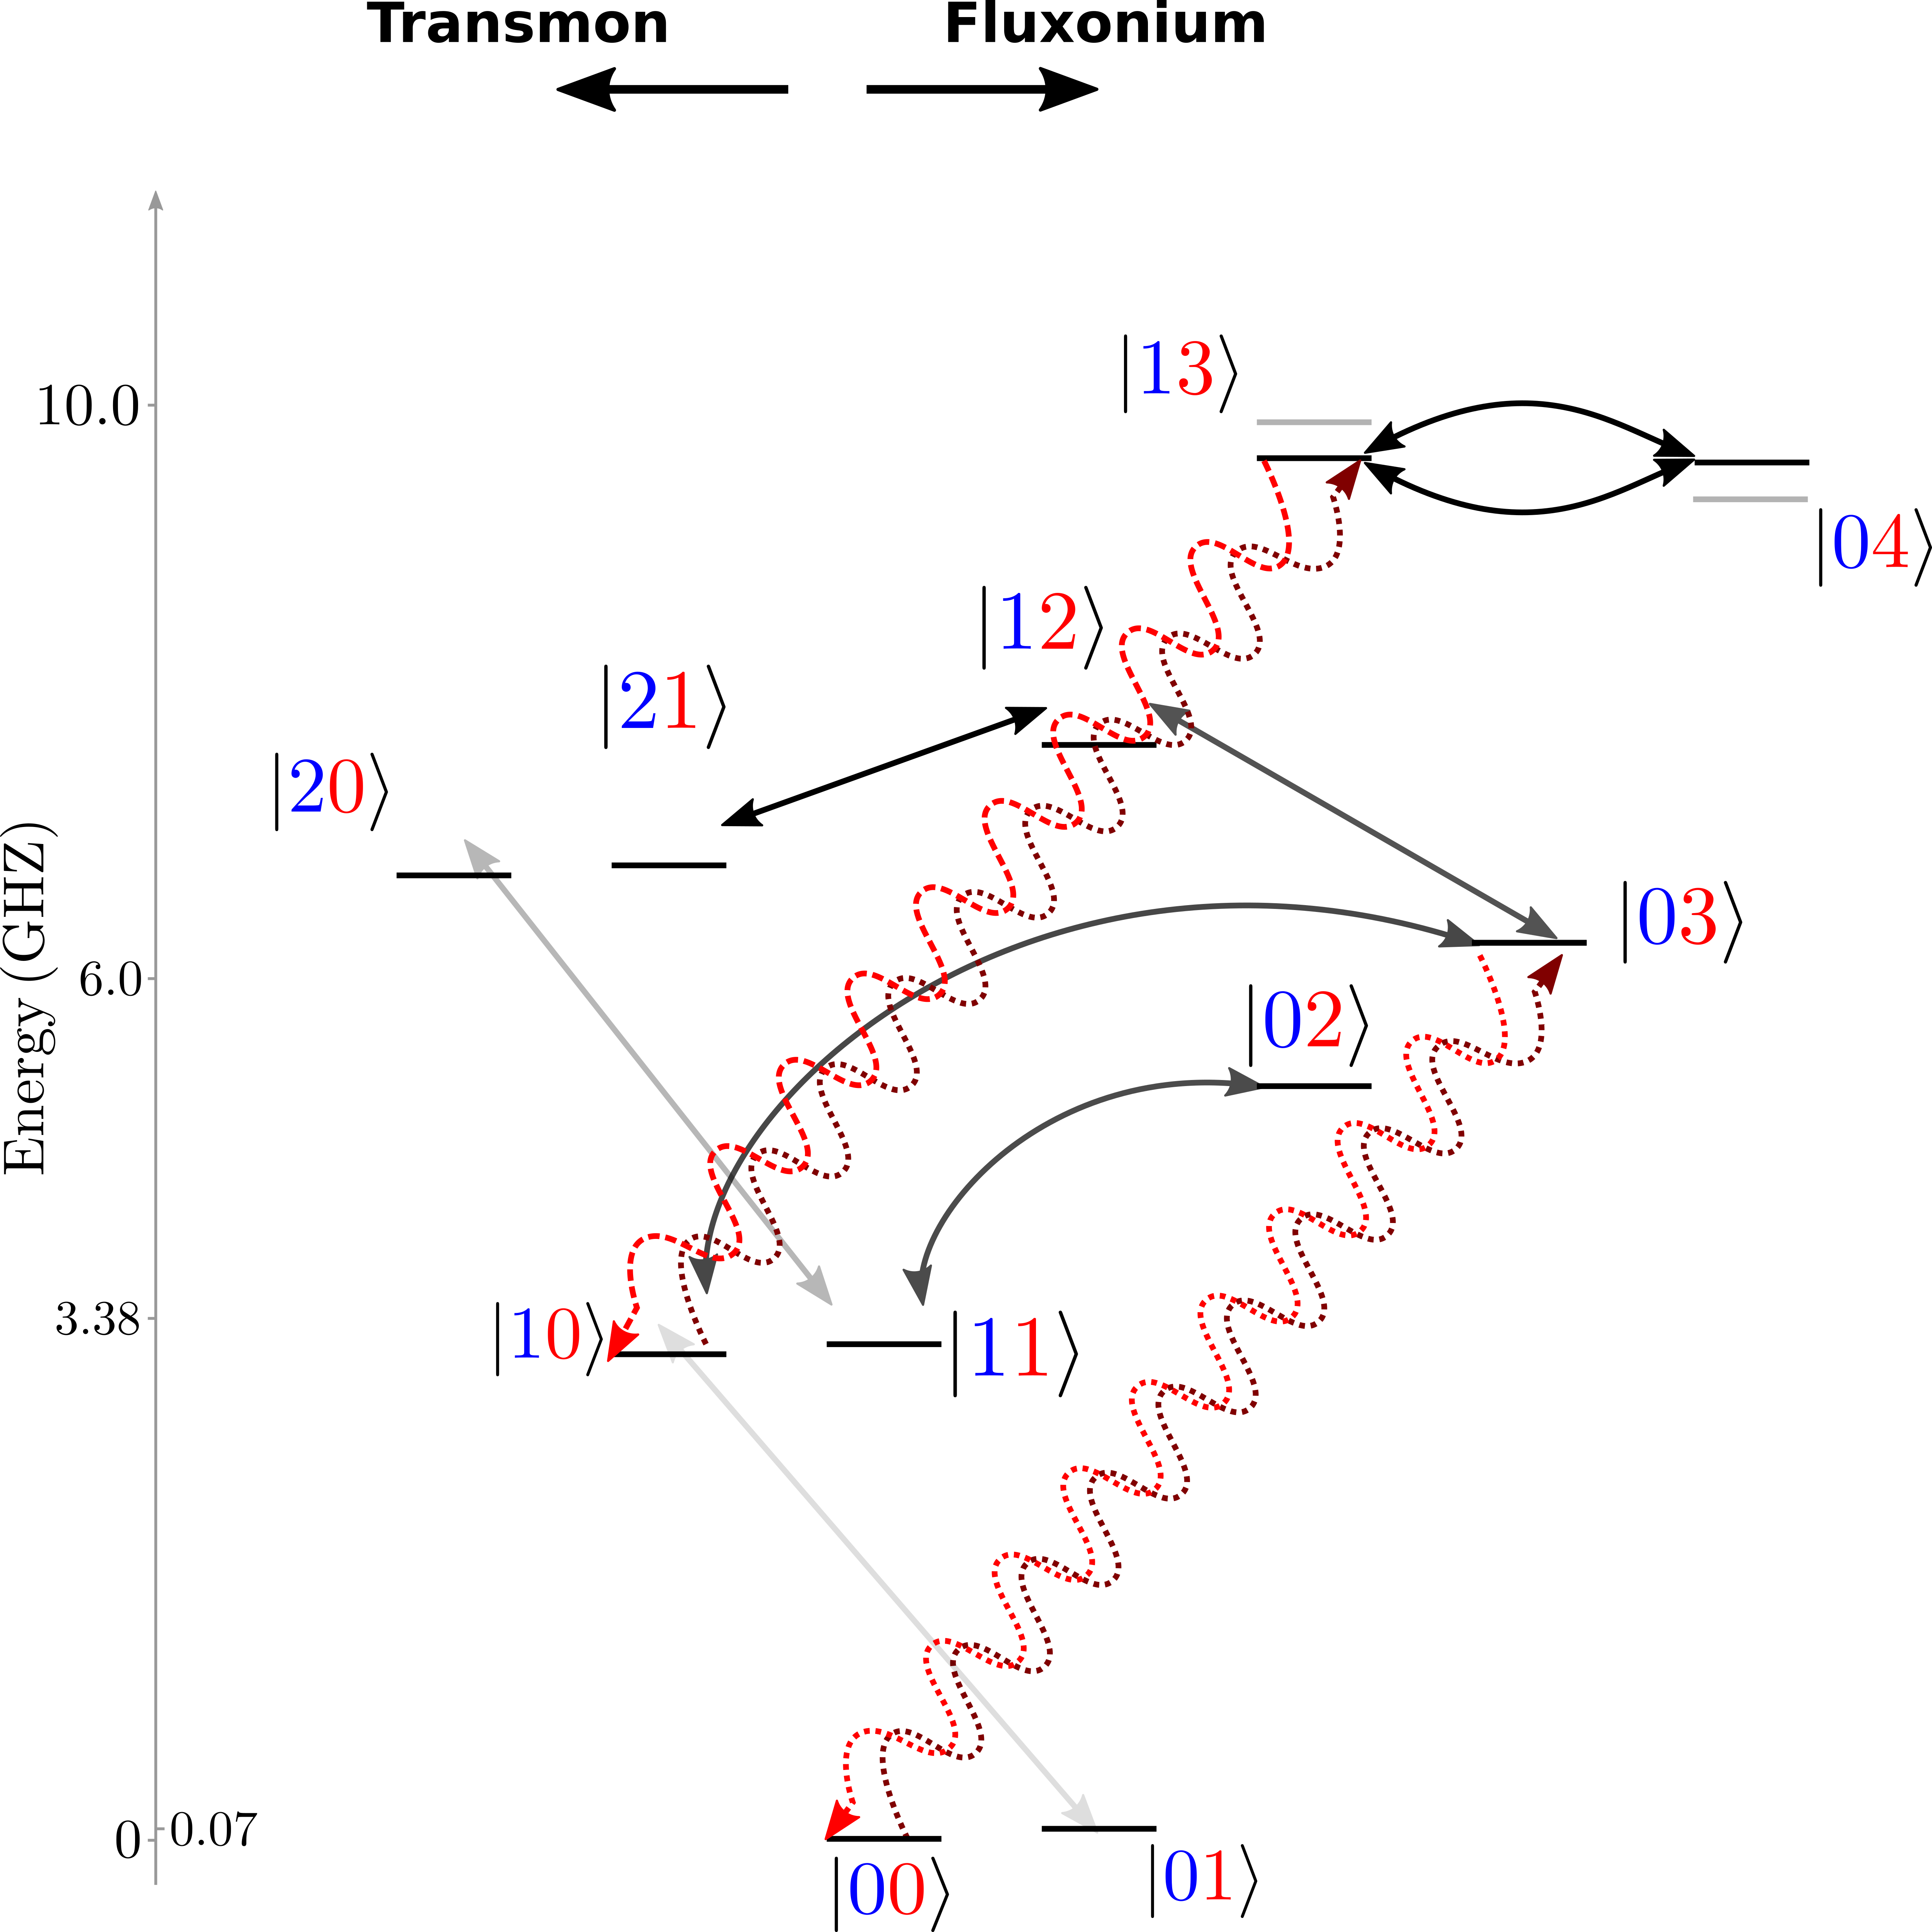

In [51]:
Image("transmon_fluxonium_couplings_04_alternative.png", width = 500)

In [52]:
omega_t_res = 3.378 # GHz to match the 3-4 transition of the fluxonium
trans_res = pysqkit.qubits.SimpleTransmon('Tres', omega_t_res, delta_t, dim_hilbert=n_fock_t) 
energies_tres, eig_states_tres = trans_res.eig_states(levels_t)

In [53]:
bare_energies_tresf = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        bare_energies_tresf[count] = energies_tres[k] + energies_f[m]
        count += 1
label_converter_res = np.argsort(bare_energies_tresf)

In [54]:
trans_res_flx = trans_res.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_tresf, eigstates_tresf = trans_res_flx.eig_states()

In [55]:
bare_energy_res_mat = np.zeros([levels_t, levels_f], dtype=float)
energy_res_mat = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        bare_energy_res_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, np.sort(bare_energies_tresf), 
                                                         label_converter_res)
        energy_res_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, energies_tresf, label_converter_res)

In this setup the residual $ZZ$ coupling is

In [56]:
zz_coup_res = zz(energy_res_mat)
display(Latex(r'$\xi_{{ZZ}}/2 \pi$ =  {:.5f} MHz'.format(zz_coup_res*1000)))

<IPython.core.display.Latex object>

In [57]:
def res_rabi_freq(energy_mat):
    return energy_mat[1, 3] - energy_mat[0, 4]

rabi = res_rabi_freq(energy_res_mat)
display(Latex(r'$\mathrm{{Resonant \, Rabi \, frequency}}$ =  {:.5f} MHz'.format(rabi*1000)))
    

<IPython.core.display.Latex object>

In [60]:
transmon = pysqkit.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 3.64, 
    anharm = -0.3, 
    dim_hilbert = 5
)

fluxonium = pysqkit.qubits.Fluxonium(
    label='fluxonium',
    joseph_energy=5.899, 
    charge_energy=0.973, 
    induct_energy=0.457,
    flux = 0.5,
    dim_hilbert=100
)
fluxonium.diagonalize_basis(7)

In [62]:
transmon_freqs = np.linspace(2, 8, 1000)
coup_str = 0.025
inv_states = ['00', '01', '10', '11', '03', '13']

_sys_trans_freqs = []

for freq in transmon_freqs:
    _transmon = pysqkit.qubits.SimpleTransmon(label='transmon', max_freq = freq, anharm = -0.3, dim_hilbert = 3)
    _system = _transmon.couple_to(fluxonium, coupling=pysqkit.couplers.capacitive_coupling, strength=coup_str)
    _bare_energies = _system.eig_energies(bare_system=True)

    _level_inds = np.array([_system.state_index(state, bare_energies=_bare_energies) for state in inv_states])
    _inds = np.argsort(_level_inds)
    
    level_inds = [_level_inds[i] for i in _inds]
    labels = [inv_states[ind] for ind in _inds]
    
    eig_energies = _system.eig_energies(levels=level_inds)

    trans_freqs = xr.DataArray(
        eig_energies[:,np.newaxis] - eig_energies, 
        dims=['out_state', 'in_state'], 
        coords=dict(
            transmon_freq=freq,
            out_state=labels, 
            in_state=labels
        )
    )
    _sys_trans_freqs.append(trans_freqs)
    
sys_freq_scan = xr.concat(_sys_trans_freqs, dim='transmon_freq')

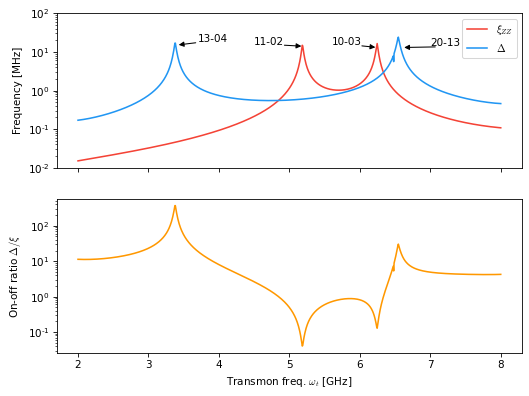

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

crosstalk_strengths = sys_freq_scan.sel(in_state='01', out_state='11') - sys_freq_scan.sel(in_state='00', out_state='10')
int_strengths = sys_freq_scan.sel(in_state='00', out_state='03') - sys_freq_scan.sel(in_state='10', out_state='13')

axs[0].plot(sys_freq_scan.transmon_freq, np.abs(crosstalk_strengths)*1e3, color='#f44336', label=r'$\xi_{ZZ}$')
axs[0].plot(sys_freq_scan.transmon_freq, np.abs(int_strengths)*1e3, color='#2196f3', label=r'$\Delta$')

axs[0].text(7.0, 14, '20-13')
axs[0].annotate("", xy=(6.6, 13), xytext=(7.1, 13.5), arrowprops=dict(arrowstyle='-|>', fc='k'))
axs[0].text(5.6, 15, '10-03')
axs[0].annotate("", xy=(6.25, 13), xytext=(6, 14.5), arrowprops=dict(arrowstyle='-|>', fc='k'))
axs[0].text(3.7, 18, '13-04')
axs[0].annotate("", xy=(3.4, 15), xytext=(3.7, 17.5), arrowprops=dict(arrowstyle='-|>', fc='k'))
axs[0].text(4.5, 15.5, '11-02')
axs[0].annotate("", xy=(5.2, 14), xytext=(4.9, 15), arrowprops=dict(arrowstyle='-|>', fc='k'))

axs[0].set_yscale('log')
axs[0].set_ylabel("Frequency [MHz]")
axs[0].set_yticks([100, 10, 1, 1e-1, 1e-2])
axs[0].legend()


axs[1].plot(sys_freq_scan.transmon_freq, np.abs(int_strengths)/np.abs(crosstalk_strengths), color='#ff9800')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'On-off ratio $\Delta / \xi$')
axs[1].set_xlabel("Transmon freq. $\omega_{t}$ [GHz]")

plt.show()

In [67]:
_transmon = pysqkit.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 4, 
    anharm = -0.3, 
    dim_hilbert = 5
)

joseph_energies = np.linspace(4, 8, 500)
coup_str = 0.025
inv_states = ['00', '01', '10', '11', '03', '13']

_qubit_trans_freqs = []
_sys_trans_freqs = []

for joseph_energy in joseph_energies:
    _fluxonium  = pysqkit.qubits.Fluxonium(
        label='fluxonium',
        joseph_energy=joseph_energy, 
        charge_energy=0.973, 
        induct_energy=0.457,
        flux = 0.5,
        dim_hilbert=100
    )
    _fluxonium.diagonalize_basis(7)
    eig_energies = _fluxonium.eig_energies()
    _qubit_trans_freqs.append(eig_energies[:,np.newaxis] - eig_energies)
    
    _system = _transmon.couple_to(_fluxonium, coupling=pysqkit.couplers.capacitive_coupling, strength=coup_str)
    _bare_energies = _system.eig_energies(bare_system=True)

    _level_inds = np.array([_system.state_index(state, bare_energies=_bare_energies) for state in inv_states])
    _inds = np.argsort(_level_inds)
    
    level_inds = [_level_inds[i] for i in _inds]
    labels = [inv_states[ind] for ind in _inds]
    
    eig_energies = _system.eig_energies(levels=level_inds)

    trans_freqs = xr.DataArray(
        eig_energies[:,np.newaxis] - eig_energies, 
        dims=['out_state', 'in_state'], 
        coords=dict(
            joseph_energy=joseph_energy,
            out_state=labels, 
            in_state=labels
        )
    )
    _sys_trans_freqs.append(trans_freqs)

qubit_freq_scan = xr.DataArray(
    _qubit_trans_freqs,
    dims=['joseph_energy', 'out_state', 'in_state'],
    coords=dict(
        joseph_energy=joseph_energies,
        out_state=[str(i) for i in range(7)],
        in_state=[str(i) for i in range(7)]
    )
)

sys_freq_scan = xr.concat(_sys_trans_freqs, dim='joseph_energy')

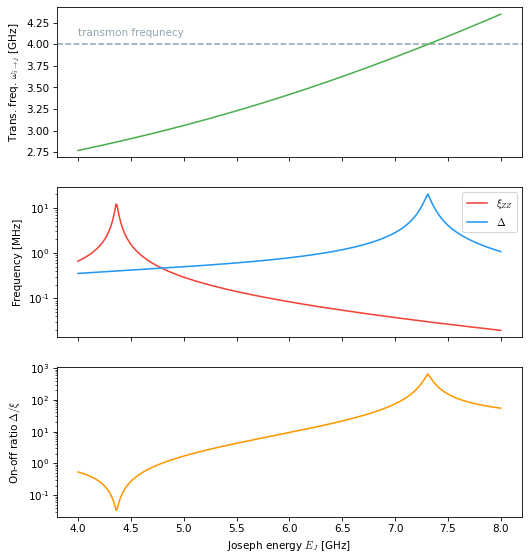

In [68]:
fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

axs[0].axhline(4, linestyle='--', color='#90a4ae')
axs[0].text(4, 4.1, 'transmon frequnecy', color='#90a4ae')
axs[0].plot(qubit_freq_scan.joseph_energy, qubit_freq_scan.sel(in_state='3', out_state='4'), label=r'$\left|3\right\rangle \rightarrow \left|4\right\rangle$', color='#4caf50')

axs[0].set_ylabel(r'Trans. freq. $\omega_{i \rightarrow j}$ [GHz]')

crosstalk_strengths = sys_freq_scan.sel(in_state='01', out_state='11') - sys_freq_scan.sel(in_state='00', out_state='10')
int_strengths = sys_freq_scan.sel(in_state='00', out_state='03') - sys_freq_scan.sel(in_state='10', out_state='13')

axs[1].plot(sys_freq_scan.joseph_energy, np.abs(crosstalk_strengths)*1e3, color='#f44336', label=r'$\xi_{ZZ}$')
axs[1].plot(sys_freq_scan.joseph_energy, np.abs(int_strengths)*1e3, color='#2196f3', label=r'$\Delta$')

axs[1].set_yscale('log')
axs[1].set_ylabel("Frequency [MHz]")
axs[1].set_yticks([10, 1, 1e-1])
axs[1].legend()


axs[2].plot(sys_freq_scan.joseph_energy, np.abs(int_strengths)/np.abs(crosstalk_strengths), color='#ff9800')
axs[2].set_yscale('log')
axs[2].set_ylabel(r'On-off ratio $\Delta / \xi$')
axs[2].set_xlabel("Joseph energy $E_{J}$ [GHz]")

plt.show()

In [69]:
_transmon = pysqkit.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 4, 
    anharm = -0.3, 
    dim_hilbert = 5
)

_fluxonium  = pysqkit.qubits.Fluxonium(
        label='fluxonium',
        joseph_energy=7.500, 
        charge_energy=0.973, 
        induct_energy=0.457,
        flux = 0.5,
        dim_hilbert=100
)
_fluxonium.diagonalize_basis(7)

coup_strengths = np.linspace(0.01, 0.25, 500)
inv_states = ['00', '01', '10', '11', '03', '13']
_sys_trans_freqs = []

_sys_trans_freqs = []
for coup_str in coup_strengths:
    _system = _transmon.couple_to(_fluxonium, coupling=pysqkit.couplers.capacitive_coupling, strength=coup_str)
    _bare_energies = _system.eig_energies(bare_system=True)

    _level_inds = np.array([_system.state_index(state, bare_energies=_bare_energies) for state in inv_states])
    _inds = np.argsort(_level_inds)
    
    level_inds = [_level_inds[i] for i in _inds]
    labels = [inv_states[ind] for ind in _inds]
    
    eig_energies = _system.eig_energies(levels=level_inds)

    trans_freqs = xr.DataArray(
        eig_energies[:,np.newaxis] - eig_energies, 
        dims=['out_state', 'in_state'], 
        coords=dict(
            coup_strength=coup_str,
            out_state=labels, 
            in_state=labels
        )
    )
    _sys_trans_freqs.append(trans_freqs)
    
sys_freq_scan = xr.concat(_sys_trans_freqs, dim='coup_strength')

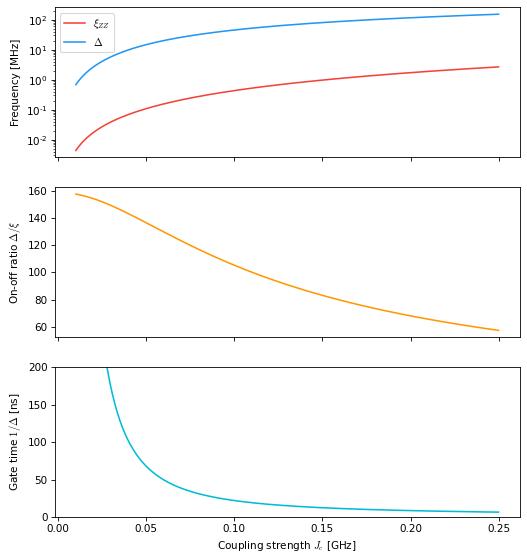

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

crosstalk_strengths = sys_freq_scan.sel(in_state='01', out_state='11') - sys_freq_scan.sel(in_state='00', out_state='10')
int_strengths = sys_freq_scan.sel(in_state='00', out_state='03') - sys_freq_scan.sel(in_state='10', out_state='13')

axs[0].plot(sys_freq_scan.coup_strength, np.abs(crosstalk_strengths)*1e3, color='#f44336', label=r'$\xi_{ZZ}$')
axs[0].plot(sys_freq_scan.coup_strength, np.abs(int_strengths)*1e3, color='#2196f3', label=r'$\Delta$')

axs[0].set_yscale('log')
axs[0].set_ylabel("Frequency [MHz]")
axs[0].legend()


axs[1].plot(sys_freq_scan.coup_strength, np.abs(int_strengths)/np.abs(crosstalk_strengths), color='#ff9800')
axs[1].set_ylabel(r'On-off ratio $\Delta / \xi$')

axs[2].plot(sys_freq_scan.coup_strength, 1/np.abs(int_strengths), color='#00bcd4')
axs[2].set_ylim(0, 200)
axs[2].set_ylabel('Gate time $1/\Delta$ [ns]')
axs[2].set_xlabel("Coupling strength $J_{c}$ [GHz]")

plt.show()

In [113]:
transmon = pysqkit.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 4, 
    anharm = -0.3, 
    dim_hilbert = 5
)

fluxonium  = pysqkit.qubits.Fluxonium(
        label='fluxonium',
        joseph_energy=7.5, #res case here corresponds to about 7.310
        charge_energy=0.973, 
        induct_energy=0.457,
        flux = 0.5,
        dim_hilbert=100
)
fluxonium.diagonalize_basis(7)
system = transmon.couple_to(fluxonium, coupling=pysqkit.couplers.capacitive_coupling, strength=0.04)

_bare_energies = system.eig_energies(bare_system=True)

_level_inds = np.array([system.state_index(state, bare_energies=_bare_energies) for state in inv_states])
_inds = np.argsort(_level_inds)

level_inds = [_level_inds[i] for i in _inds]
labels = [inv_states[ind] for ind in _inds]

eig_energies = system.eig_energies(levels=level_inds)

trans_freqs = xr.DataArray(
    eig_energies[:,np.newaxis] - eig_energies, 
    dims=['out_state', 'in_state'], 
    coords=dict(
        coup_strength=coup_str,
        out_state=labels, 
        in_state=labels
    )
)

In [114]:
crosstalk_strength = float(trans_freqs.sel(in_state='01', out_state='11') - trans_freqs.sel(in_state='00', out_state='10'))
display(Latex(r'$\xi_{{ZZ}}/2 \pi$ =  {:.5f} MHz'.format(crosstalk_strength*1e3)))

<IPython.core.display.Latex object>

In [115]:
int_strengths = float(abs(trans_freqs.sel(in_state='10', out_state='13') - trans_freqs.sel(in_state='00', out_state='03')))
display(Latex(r'$\Delta_{{13-04}} = $ {:.5f} MHz'.format(int_strengths*1e3)))

<IPython.core.display.Latex object>

In [116]:
display(Latex(r'$1/\Delta_{{13-04}} = $ {:.5f} ns'.format(1/int_strengths)))

<IPython.core.display.Latex object>

# 2. CPHASE-like gate using the $\lvert 10 \rangle-\lvert 03 \rangle$ transition

We consider a transmon that has an initial frequency of $6.8 \, \mathrm{GHz}$.

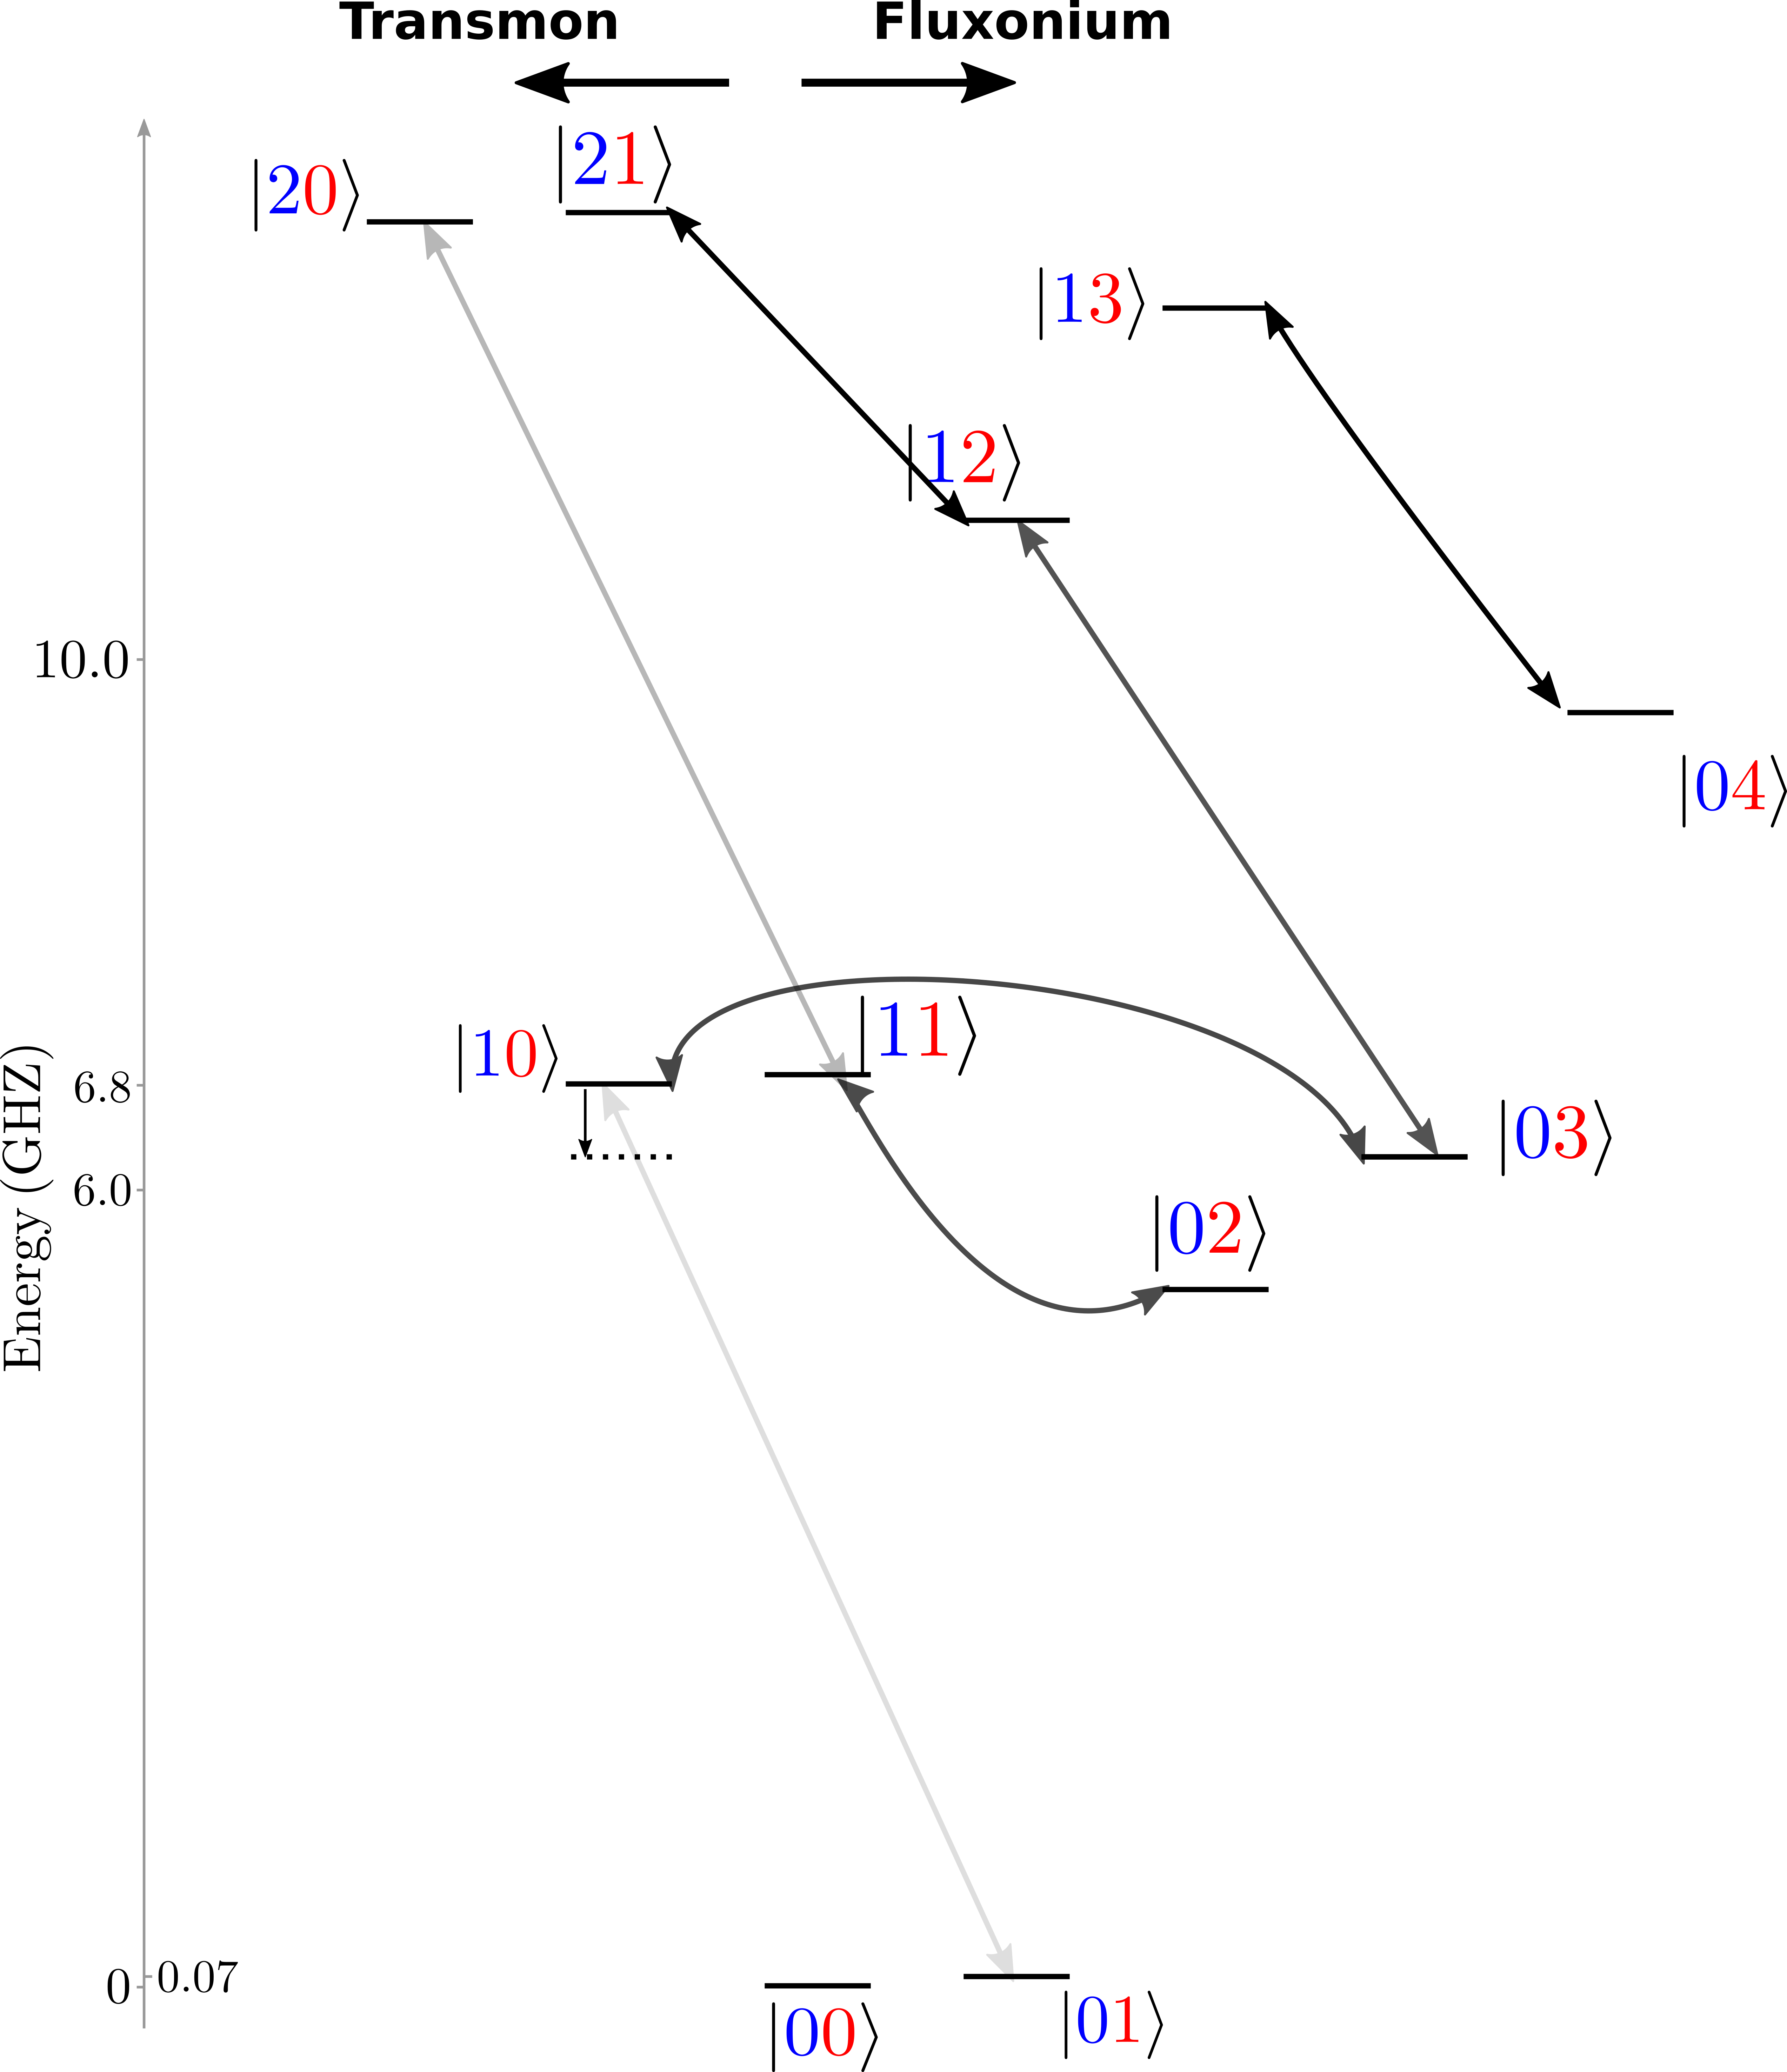

In [58]:
Image("transmon_fluxonium_cphase_10-03.png", width = 600)

In [22]:
omega_in = 6.8
n_points = 1000
phi_vec = np.linspace(0.0, 0.2, n_points) #phi/phi_0
level_in_plot = 2
level_f_plot = 5
energy_phi_vec = np.zeros([level_f_plot - level_in_plot, n_points], dtype=float)
trans_high = pysqkit.qubits.SimpleTransmon('Thigh', omega_in, delta_t, dim_hilbert=n_fock_t)
energies_t_high = trans_high.eig_energies()
bare_energies_high = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        bare_energies_high[count] = energies_t_high[k] + energies_f[m]
        count += 1
label_converter_high = np.argsort(bare_energies_high)
bare_energy_mat_high = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        bare_energy_mat_high[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, np.sort(bare_energies_high), 
                                                         label_converter_high)
jc_new = 0.1*jc_ficheux

In [23]:
trans_high_flx = trans_high.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_new)
energies_thighf, eigstates_thighf = trans_high_flx.eig_states()

In [24]:
energy_high_mat = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        energy_high_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, energies_thighf, label_converter_high)

In this setup the residual $ZZ$ coupling is

In [25]:
zz_coup_high = zz(energy_high_mat)
display(Latex(r'$\xi_{{ZZ}}/2 \pi$ =  {:.5f} MHz'.format(zz_coup_high*1000)))

<IPython.core.display.Latex object>

In [26]:
start = time.time()

for i in range(0, n_points):
    omega_phi = omega_in*np.sqrt(np.abs(np.cos(np.pi*phi_vec[i])))
    trans_phi = pysqkit.qubits.SimpleTransmon('Thigh', omega_phi, delta_t, dim_hilbert=n_fock_t)
    energies_phi, eig_states_phi = trans_phi.eig_states(levels_t)
    flx_trans_phi = trans_phi.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_new)
    energies_phi = flx_trans_phi.eig_energies()
    energies_phi = energies_phi - energies_phi[0]
    energy_phi_vec[:, i] = energies_phi[level_in_plot: level_f_plot]
    

end=time.time()

print("Computation time: " + str(end - start) + ' s')

Computation time: 9.979859828948975 s


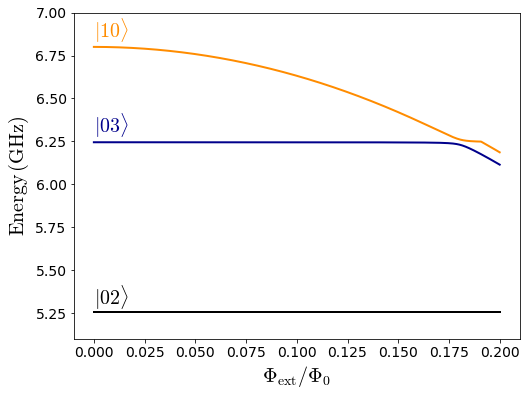

In [27]:
def plot_levels_phi(
    phi_vec: np.ndarray,
    energy_phi_vec: np.ndarray,
    opt: dict
) -> None:
    color_plot = ['black', 'darkblue', 'darkorange']
    fig, ax = plt.subplots(figsize=(8, 6))
    levels = energy_phi_vec.shape[0]
    for lev in range(0, levels):
        ax.plot(phi_vec, energy_phi_vec[lev, :], color=color_plot[lev], linewidth=opt['lw'])
    ax.axes.set_xlabel('$\Phi_{\mathrm{ext}}/\Phi_0$', fontsize=opt['fs'])
    ax.axes.set_ylabel('$\mathrm{Energy} \, (\mathrm{GHz})$', fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.text(0, 5.3, '$\\vert 02 \\rangle$', fontsize=opt['fs'], color=color_plot[0])
    ax.text(0, 6.3, '$\\vert 03 \\rangle$', fontsize=opt['fs'], color=color_plot[1])
    ax.text(0, 6.85, '$\\vert 10 \\rangle$', fontsize=opt['fs'], color=color_plot[2])
    ax.set_ylim(5.1, 7.0)
    plt.show()

plot_levels_phi(phi_vec, energy_phi_vec, plot_setup)

In [28]:
avc = np.min(energy_phi_vec[2, :] - energy_phi_vec[1, :])
display(Latex(r'$\mathrm{{Avoided \, Crossing}}$ =  {:.5f} MHz'.format(avc*1000)))

<IPython.core.display.Latex object>